In [1]:
import os
import pandas as pd
import numpy as np
from nilearn import maskers
from joblib import Parallel, delayed
from tqdm import tqdm
import warnings
import requests
import tarfile
import io
import glob

# --- CONFIGURATION ---
DATASET_ROOT = r'C:\Users\T2430431\Downloads\RawDataBIDS'
OUTPUT_FILE = r'C:\Users\T2430431\Downloads\RawDataBIDS\adhd_deepfmri_aal.npy'
ATLAS_DIR = r'C:\Users\T2430431\Downloads\Atlas_Cache' 
N_JOBS = -1 
TARGET_LENGTH = 172

# --- STEP 1: ATLAS SETUP (MANUAL LOCAL LOAD) ---
if not os.path.exists(ATLAS_DIR):
    os.makedirs(ATLAS_DIR)

# Try to locate the .nii file recursively in the cache
found_atlas = glob.glob(os.path.join(ATLAS_DIR, '**', 'ROI_MNI_V4.nii'), recursive=True)

if not found_atlas:
    print("Atlas not found. Downloading Classic AAL (SSL Verify=False)...")
    url = "https://www.gin.cnrs.fr/wp-content/uploads/aal_for_SPM12.tar.gz"
    try:
        response = requests.get(url, verify=False, stream=True)
        response.raise_for_status()
        with tarfile.open(fileobj=io.BytesIO(response.content), mode="r:gz") as tar:
            tar.extractall(path=ATLAS_DIR)
        print("Download successful!")
        found_atlas = glob.glob(os.path.join(ATLAS_DIR, '**', 'ROI_MNI_V4.nii'), recursive=True)
    except Exception as e:
        print(f"Download failed: {e}")
        exit()

if not found_atlas:
    print("CRITICAL ERROR: ROI_MNI_V4.nii still not found after download.")
    exit()

aal_nii_path = found_atlas[0]
print(f"Using Atlas: {aal_nii_path}")

# --- STEP 2: MASKER SETUP ---
masker = maskers.NiftiLabelsMasker(
    labels_img=aal_nii_path,
    standardize="zscore_sample", 
    smoothing_fwhm=6,          # 6mm smoothing
    low_pass=0.08,             # f < 0.08Hz
    high_pass=0.009,           # f > 0.009Hz
    t_r=2.0,                   # Default TR
    detrend=True,
    verbose=0
)

# --- STEP 3: PROCESSING FUNCTION ---
def process_subject(row_data):
    site_path, participant_id, dx_raw, gender_raw, age_raw, iq_raw, tr_val = row_data
    
    try:
        sub_id = str(participant_id)
        # Handle "sub-001" vs "001" variations
        formatted_sub_id = f"sub-{sub_id.zfill(7)}" if not sub_id.startswith('sub-') else sub_id
        
        # BIDS PATH FIX: Search recursively for the bold file inside the subject folder
        subject_dir = os.path.join(site_path, formatted_sub_id)
        
        fmri_path = None
        if os.path.exists(subject_dir):
            # Recursive search for any file ending in 'bold.nii.gz'
            # This finds 'sub-1018959_ses-1_task-rest_acq-1_run-1_bold.nii.gz'
            # regardless of ses-1 or func folders.
            bold_files = glob.glob(os.path.join(subject_dir, '**', '*bold.nii.gz'), recursive=True)
            if bold_files:
                fmri_path = bold_files[0] # Take the first bold file found
        
        if not fmri_path: return None

        # Assign Labels
        label = 0
        val = str(dx_raw).lower()
        if any(x in val for x in ["typically", "control", "td", "0"]):
            label = 0
        elif any(x in val for x in ["adhd", "1", "2", "3"]):
            label = 1
        else:
            return None

        # Extract Time Series
        masker.t_r = tr_val 
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            # AAL extracts 116 regions usually
            full_time_series = masker.fit_transform(fmri_path)

        # Enforce Fixed Length
        n_time_points, n_regions = full_time_series.shape
        
        if n_time_points < TARGET_LENGTH:
            return None 
        
        final_time_series = full_time_series[:TARGET_LENGTH, :]

        # SLICE TO 90 REGIONS (Paper requirement)
        if n_regions >= 90:
            final_time_series = final_time_series[:, :90]
        else:
            return None

        # Extract Phenotypes
        gender = 0 if str(gender_raw).lower() == 'male' else 1
        try: age = float(age_raw)
        except: age = 0.0
        try: iq = float(iq_raw)
        except: iq = 100.0
        if np.isnan(iq): iq = 100.0

        return {
            'time_series': final_time_series.astype(np.float32), 
            'pheno': [age, gender, iq], 
            'label': label,
            'site': os.path.basename(site_path)
        }

    except Exception as e:
        return None

if __name__ == "__main__":
    # Site TR configuration (NYU=2.0, NeuroIMAGE=1.96, etc.)
    site_config = {
        'NYU': 2.0, 'NeuroIMAGE': 1.96, 'Peking_1': 2.0, 'Peking_2': 2.0, 'Peking_3': 2.0,
        'KKI': 2.5, 'OHSU': 2.5, 'WashU': 2.5, 'Pittsburgh': 1.5 
    }
    
    tasks = []
    
    print("Scanning dataset directories...")
    for site, tr in site_config.items():
        site_path = os.path.join(DATASET_ROOT, site)
        # Note: Your debug output showed phenotypic files are named 'KKI_phenotypic.csv'
        # We need to detect either .tsv or .csv
        possible_phenos = [
            os.path.join(site_path, 'participants.tsv'),
            os.path.join(DATASET_ROOT, f"{site}_phenotypic.csv")
        ]
        
        pheno_file = None
        for p in possible_phenos:
            if os.path.exists(p):
                pheno_file = p
                break
        
        if not pheno_file: 
            print(f"Skipping {site}: No phenotypic file found.")
            continue
        
        try:
            # Handle CSV vs TSV
            if pheno_file.endswith('.tsv'):
                df = pd.read_csv(pheno_file, sep='\t', encoding_errors='replace')
            else:
                df = pd.read_csv(pheno_file, encoding_errors='replace')
                
            df.columns = [c.lower() for c in df.columns]
            
            # Find diagnosis column
            target_col = next((c for c in ['dx', 'diagnosis', 'adhd_status', 'group'] if c in df.columns), None)
            # Find subject ID column (sometimes it's 'scanDir_ID' or 'Subject')
            id_col = next((c for c in ['participant_id', 'scandir_id', 'subject'] if c in df.columns), None)
            
            if not target_col or not id_col: 
                print(f"Skipping {site}: Columns missing in {os.path.basename(pheno_file)}")
                continue

            for _, row in df.iterrows():
                # Handle IQ (optional)
                iq_val = np.nan 
                if 'iq' in df.columns: iq_val = row['iq']
                elif 'verbal_iq' in df.columns: iq_val = row['verbal_iq']

                # Handle Gender (optional)
                gender_val = row['gender'] if 'gender' in df.columns else '0'

                tasks.append((
                    site_path, 
                    row[id_col], 
                    row[target_col], 
                    gender_val, 
                    row['age'] if 'age' in df.columns else 0, 
                    iq_val, 
                    tr
                ))
        except Exception as e:
            print(f"Error preparing {site}: {e}")

    print(f"Found {len(tasks)} potential scans.")
    print(f"Starting Processing (Target Length: {TARGET_LENGTH}, Atlas: AAL 90)...")
    
    results = Parallel(n_jobs=N_JOBS, backend='loky')(
        delayed(process_subject)(t) for t in tqdm(tasks, unit="scan")
    )

    valid_results = [r for r in results if r is not None]
    
    print(f"\nProcessing Complete!")
    print(f"Successfully processed: {len(valid_results)} subjects")
    
    np.save(OUTPUT_FILE, valid_results)
    print(f"Saved to {OUTPUT_FILE}")
    
    if len(valid_results) > 0:
        print(f"Shape check: {valid_results[0]['time_series'].shape}")

Atlas not found. Downloading Classic AAL (SSL Verify=False)...


C:\ProgramData\anaconda3\Lib\site-packages\urllib3\connectionpool.py:1100: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.gin.cnrs.fr'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


Download successful!
Using Atlas: C:\Users\T2430431\Downloads\Atlas_Cache\aal\ROI_MNI_V4.nii
Scanning dataset directories...
Found 1036 potential scans.
Starting Processing (Target Length: 172, Atlas: AAL 90)...


100%|████████████████████████████████████████████████████████████████████████████| 1036/1036 [07:54<00:00,  2.18scan/s]



Processing Complete!
Successfully processed: 637 subjects
Saved to C:\Users\T2430431\Downloads\RawDataBIDS\adhd_deepfmri_aal.npy
Shape check: (172, 90)


--- STARTING SANITY CHECK ---
Loading: C:\Users\T2430431\Downloads\RawDataBIDS\adhd_deepfmri_aal.npy
Total Subjects Loaded: 637

Scanning individual subjects...

      SANITY CHECK REPORT      
[PASS] All 637 subjects have shape (172, 90)
[PASS] No NaNs or Infinite values found.

--- Class Distribution ---
Healthy (0): 362
ADHD    (1): 275

--- Site Distribution ---
NYU: 201
NeuroIMAGE: 57
Peking_1: 187
Peking_2: 65
Peking_3: 42
Pittsburgh: 85

--- Visualizing First Subject ---


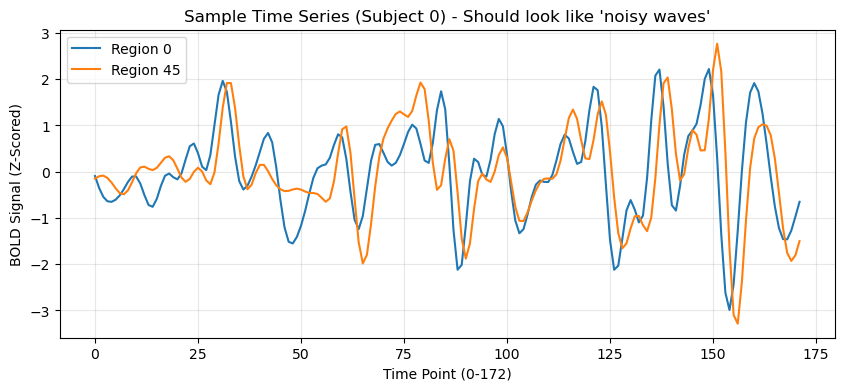

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# --- CONFIGURATION ---
INPUT_FILE = r"C:\Users\T2430431\Downloads\RawDataBIDS\adhd_deepfmri_aal.npy"
EXPECTED_SHAPE = (172, 90)

def run_sanity_check():
    print(f"--- STARTING SANITY CHECK ---")
    print(f"Loading: {INPUT_FILE}")
    
    if not os.path.exists(INPUT_FILE):
        print("ERROR: File does not exist!")
        return

    try:
        data = np.load(INPUT_FILE, allow_pickle=True)
    except Exception as e:
        print(f"CRITICAL ERROR: Could not load .npy file. It might be corrupted.\n{e}")
        return

    total_subjects = len(data)
    print(f"Total Subjects Loaded: {total_subjects}")
    
    if total_subjects == 0:
        print("FAIL: The file is valid but contains 0 subjects.")
        return

    # Initialize counters
    sites = []
    labels = []
    shapes_ok = True
    nan_found = False
    
    print("\nScanning individual subjects...")
    
    for i, subj in enumerate(data):
        # 1. Check Keys
        if not all(k in subj for k in ['time_series', 'label', 'site', 'pheno']):
            print(f"FAIL: Subject {i} is missing keys: {subj.keys()}")
            break
            
        # 2. Check Shape
        ts = subj['time_series']
        if ts.shape != EXPECTED_SHAPE:
            print(f"FAIL: Subject {i} ({subj['site']}) has wrong shape: {ts.shape}. Expected {EXPECTED_SHAPE}")
            shapes_ok = False
        
        # 3. Check for NaNs (Critical for Neural Networks)
        if np.isnan(ts).any() or np.isinf(ts).any():
            print(f"FAIL: Subject {i} contains NaN or Inf values!")
            nan_found = True
            
        # 4. Check Label Validity
        lbl = subj['label']
        if lbl not in [0, 1]:
            print(f"WARNING: Subject {i} has weird label: {lbl}")
            
        sites.append(subj['site'])
        labels.append(lbl)

    # --- REPORT ---
    print("\n" + "="*30)
    print("      SANITY CHECK REPORT      ")
    print("="*30)
    
    if shapes_ok:
        print(f"[PASS] All {total_subjects} subjects have shape {EXPECTED_SHAPE}")
    else:
        print(f"[FAIL] Some subjects have incorrect shapes.")

    if not nan_found:
        print(f"[PASS] No NaNs or Infinite values found.")
    else:
        print(f"[FAIL] Data contains corrupt values (NaN/Inf).")

    print("\n--- Class Distribution ---")
    lbl_counts = Counter(labels)
    print(f"Healthy (0): {lbl_counts.get(0, 0)}")
    print(f"ADHD    (1): {lbl_counts.get(1, 0)}")
    
    print("\n--- Site Distribution ---")
    site_counts = Counter(sites)
    for site, count in site_counts.items():
        print(f"{site}: {count}")

    # --- VISUAL CHECK ---
    # Plot the first subject's time series to ensure it looks like "noise" (good fMRI data)
    # and not a flat line (bad processing).
    print("\n--- Visualizing First Subject ---")
    first_sub = data[0]['time_series']
    plt.figure(figsize=(10, 4))
    plt.plot(first_sub[:, 0], label="Region 0") # Plot first region
    plt.plot(first_sub[:, 45], label="Region 45") # Plot middle region
    plt.title(f"Sample Time Series (Subject 0) - Should look like 'noisy waves'")
    plt.xlabel("Time Point (0-172)")
    plt.ylabel("BOLD Signal (Z-Scored)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

if __name__ == "__main__":
    import os
    run_sanity_check()